# Spatial Coincidental Match Probability Exploration

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle as pkl
import matplotlib.pyplot as plt
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

sys.path.append('/Users/cmg/dev/spatial-assocr/kde')
from location_project import kde_2d  # adaptive bw KDE 
%load_ext autoreload
%autoreload 2 # auto reload changes to kde code for faster prototyping

%matplotlib inline
sys.setrecursionlimit(10000)

## Load & format filtered data

In [2]:
# read in the filtered data
filepath = os.path.join("..", "data", "mpp_month0a_month1b_n50.csv")
mpp = pd.read_csv(filepath)
mpp.head()

,id,m,lon,lat
0,11.0,a,-117.92895,33.61891
1,11.0,a,-117.67199,33.60002
2,11.0,a,-117.92895,33.61891
3,11.0,a,-117.67199,33.60002
4,11.0,a,-117.67199,33.60002


In [3]:
# reorder the columns... kde_2d expects [id, lon, lat]
data = mpp[['id', 'lon', 'lat']]
data.head()

,id,lon,lat
0,11.0,-117.92895,33.61891
1,11.0,-117.67199,33.60002
2,11.0,-117.92895,33.61891
3,11.0,-117.67199,33.60002
4,11.0,-117.67199,33.60002


In [4]:
# convert the pandas data frame to array of arrays
# i.e., <np.array [[user_id, lon, lat], ... ] >
df = data.values
df

array([[ 1.1000000e+01, -1.1792895e+02,  3.3618910e+01],
       [ 1.1000000e+01, -1.1767199e+02,  3.3600020e+01],
       [ 1.1000000e+01, -1.1792895e+02,  3.3618910e+01],
       ...,
       [ 1.7282000e+04, -1.1795213e+02,  3.3684750e+01],
       [ 1.7282000e+04, -1.1795213e+02,  3.3684750e+01],
       [ 1.7282000e+04, -1.1795197e+02,  3.3684750e+01]])

## Fit an adaptive bandwidth KDE to the data
Do this for the entire sample (i.e., a population model). 

In [5]:
# learn the bandwidth for each point & save to file (it's expensive)
# filepath = os.path.join("..", "data", "bw_pop_k10_month0a_month1b_n50.npy")
filepath = os.path.join("..", "data", "bw_pop_k5_month0a_month1b_n50.npy")
KM_TO_LON = 0.010615
KM_TO_LAT = 0.008989
# bw_pop = kde_2d._learn_nearest_neighbors_bandwidth(
#     df[:, 1:3], k=5, lon_to_km=KM_TO_LON, lat_to_km=KM_TO_LAT, min_bw=0.1
# )
# np.save(filepath, bw_pop)
bw_pop = np.load(filepath)

In [6]:
# format the data for the KDE class; equally weight points
# <np.array [[user_id, lon, lat, bw, weight], ... ] >
pop = np.append(df, np.reshape(bw_pop, (len(df), 1)), 1)
pop = np.append(pop, np.ones((len(df), 1)), 1)

# create the KDE
kde_pop = kde_2d.KDE(pop)

In [7]:
# compute the log pdf for a given point
# < np.array [lon, lat] >
kde_pop.log_pdf(df[0][1:])

9.619453142395939

In [8]:
# sample from the KDE
# must pass in the data to do so b/c its a nonparametric model
kde_pop.sample_from_kde(pop)

[-117.97009075642963, 33.76581461047981]

### Contour plot of the density

In [9]:
data.describe()

,id,lon,lat
count,26294.000000,26294.000000,26294.000000
mean,1185.620940,-117.878634,33.726549
std,2266.328306,0.096669,0.105041
min,11.000000,-118.105640,33.422000
25%,89.000000,-117.929750,33.623655
50%,471.000000,-117.898410,33.723160
75%,1725.000000,-117.833470,33.813097
max,17282.000000,-117.572240,33.944970


In [10]:
# compute log pdf values over grid
delta = 0.01
x = np.arange(-118.2, -117.5, delta)  # longitude
y = np.arange(33.4, 34, delta)  # latitude
X, Y = np.meshgrid(x, y)
pts = np.vstack([X.ravel(), Y.ravel()]).T
z = np.apply_along_axis(kde_pop.log_pdf, 1, pts)

# filepath = os.path.join("..", "data", "kde_pop_k10_month0a_month1b_n50.npy")
# filepath = os.path.join("..", "data", "kde_pop_k5_month0a_month1b_n50.npy")
# np.save(filepath, z)
# z = np.load(filepath)

In [11]:
# save pandas to pickle to debug more later
filepath = os.path.join("..", "data", "kde_pop_k5_month0a_month1b_n50.pkl")
out = pd.DataFrame({'lon': pts[:,0], 'lat': pts[:,1], 'lpdf': z})
# out.to_pickle(filepath)
# out = pd.read_pickle(filepath)
out.head()

,lon,lat,lpdf
0,-118.20,33.4,-0.929024
1,-118.19,33.4,-0.180213
2,-118.18,33.4,-11.576547
3,-118.17,33.4,-10.123177
4,-118.16,33.4,-8.702791


In [12]:
# create the contour plot
heat = [
    go.Heatmap(
        z = out.lpdf,
        x = out.lon,
        y = out.lat,
        colorscale=[
            [1.0, 'rgb(165,0,38)'], 
            [0.8888888888888888, 'rgb(215,48,39)'], 
            [0.7777777777777778, 'rgb(244,109,67)'], 
            [0.6666666666666666, 'rgb(253,174,97)'], 
            [0.5555555555555556, 'rgb(254,224,144)'], 
            [0.4444444444444444, 'rgb(224,243,248)'], 
            [0.3333333333333333, 'rgb(171,217,233)'], 
            [0.2222222222222222, 'rgb(116,173,209)'], 
            [0.1111111111111111, 'rgb(69,117,180)'], 
            [0.0, 'rgb(49,54,149)']
        ]
    )
]

layout = go.Layout()

fig = go.Figure(data=heat, layout=layout)
iplot(fig, show_link=False)

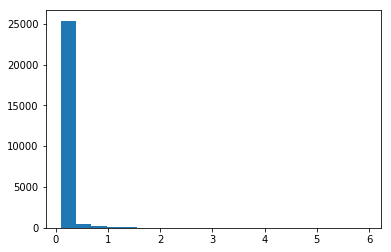

In [13]:
plt.hist(bw_pop, bins=20)
plt.show()

## Test on fewer points

In [15]:
df_test = data.values[:6,]
KM_TO_LON = 0.010615
KM_TO_LAT = 0.008989

# learn bw
bw_test = kde_2d._learn_nearest_neighbors_bandwidth(
    df_test[:, 1:3], k=3, lon_to_km=KM_TO_LON, lat_to_km=KM_TO_LAT, min_bw=0.001
)

# create kde object
test = np.append(df_test, np.reshape(bw_test, (len(df_test), 1)), 1)
test = np.append(test, np.ones((len(df_test), 1)), 1)
kde_test = kde_2d.KDE(test)

# evaluate kde over grid
delta = 0.01
x = np.arange(-118.2, -117.5, delta)  # longitude
y = np.arange(33.4, 34, delta)  # latitude
X, Y = np.meshgrid(x, y)
pts = np.vstack([X.ravel(), Y.ravel()]).T
z = np.apply_along_axis(kde_test.log_pdf, 1, pts)

out = pd.DataFrame({'lon': pts[:,0], 'lat': pts[:,1], 'lpdf': z})

# create the contour plot
heat = [
    go.Heatmap(
        z = out.lpdf,
        x = out.lon,
        y = out.lat,
        colorscale=[
            [1.0, 'rgb(165,0,38)'], 
            [0.8888888888888888, 'rgb(215,48,39)'], 
            [0.7777777777777778, 'rgb(244,109,67)'], 
            [0.6666666666666666, 'rgb(253,174,97)'], 
            [0.5555555555555556, 'rgb(254,224,144)'], 
            [0.4444444444444444, 'rgb(224,243,248)'], 
            [0.3333333333333333, 'rgb(171,217,233)'], 
            [0.2222222222222222, 'rgb(116,173,209)'], 
            [0.1111111111111111, 'rgb(69,117,180)'], 
            [0.0, 'rgb(49,54,149)']
        ]
    )
]

layout = go.Layout()
fig = go.Figure(data=heat, layout=layout)
iplot(fig, show_link=False)